In [1]:
# https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/

In [2]:
%cd /content/

/content


In [3]:
import os
PATH = 'data'
try:
  os.mkdir('data')
except:
  print("folder alreadexists")

In [4]:
from torchvision import datasets

dataset = datasets.MNIST(root=PATH, download=True)
for idx, (img, _) in enumerate(dataset):
    img.save('{:05d}.jpg'.format(idx))


100%|██████████| 9912422/9912422 [00:00<00:00, 91924107.79it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9904799.17it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25155190.60it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7494307.15it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
PATH_RESULTS = 'results'
PATH_TESTS = 'data2_test'

try:
  os.mkdir(PATH_RESULTS)
  os.mkdir(PATH_TESTS)
except:
  print("folder alreadexists")

In [ ]:
# example from https://github.com/pytorch/examples/blob/master/vae/main.py
# commented and type annotated by Charl Botha <cpbotha@vxlabs.com>

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# changed configuration to this instead of argparse for easier interaction
CUDA = True
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 10

# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 20
ZDIMS = 20

# I do this so that the MNIST dataset is downloaded where I want it
# os.chdir("data")

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

# Download or load downloaded MNIST dataset
# shuffle data at every epoch
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data2', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# Same for test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data2_test', train=False, download=True, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        # 28 x 28 pixels = 784 input pixels, 400 outputs
        self.fc1 = nn.Linear(784, 400)
        # rectified linear unit layer from 400 to 400
        # max(0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS)  # mu layer
        self.fc22 = nn.Linear(400, ZDIMS)  # logvariance layer
        # this last layer bottlenecks through ZDIMS connections

        # DECODER
        # from bottleneck to hidden 400
        self.fc3 = nn.Linear(ZDIMS, 400)
        # from hidden 400 to 784 outputs
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        """Input vector x -> fully connected 1 -> ReLU -> (fully connected
        21, fully connected 22)

        Parameters
        ----------
        x : [128, 784] matrix; 128 digits of 28x28 pixels each

        Returns
        -------

        (mu, logvar) : ZDIMS mean units one for each latent dimension, ZDIMS
            variance units one for each latent dimension

        """

        # h1 is [128, 400]
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        """THE REPARAMETERIZATION IDEA:

        For each training sample (we get 128 batched at a time)

        - take the current learned mu, stddev for each of the ZDIMS
          dimensions and draw a random sample from that distribution
        - the whole network is trained so that these randomly drawn
          samples decode to output that looks like the input
        - which will mean that the std, mu will be learned
          *distributions* that correctly encode the inputs
        - due to the additional KLD term (see loss_function() below)
          the distribution will tend to unit Gaussians

        Parameters
        ----------
        mu : [128, ZDIMS] mean matrix
        logvar : [128, ZDIMS] variance matrix

        Returns
        -------

        During training random sample from the learned ZDIMS-dimensional
        normal distribution; during inference its mean.

        """

        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation
            std = logvar.mul(0.5).exp_()  # type: Variable
            # - std.data is the [128,ZDIMS] tensor that is wrapped by std
            # - so eps is [128,ZDIMS] with all elements drawn from a mean 0
            #   and stddev 1 normal distribution that is 128 samples
            #   of random ZDIMS-float vectors
            eps = Variable(std.data.new(std.size()).normal_())
            # - sample from a normal distribution with standard
            #   deviation = std and mean = mu by multiplying mean 0
            #   stddev 1 sample with desired std and mu, see
            #   https://stats.stackexchange.com/a/16338
            # - so we have 128 sets (the batch) of random ZDIMS-float
            #   vectors sampled from normal distribution with learned
            #   std and mu for the current input
            return eps.mul(std).add_(mu)

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
# if CUDA:
#     model.cuda()


def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

# Dr Diederik Kingma: as if VAEs weren't enough, he also gave us Adam!
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        # if CUDA:
        #     data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # print("loss, loss.item()", loss, loss.item())
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.item() #loss.data[0]
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data))) #loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        # if CUDA:
        #     # make sure this lives on the GPU
        #     data = data.cuda()

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item() #data[0]
        if i == 0:
          n = min(data.size(0), 8)
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    sample = Variable(torch.randn(64, ZDIMS))
    # if CUDA:
    #     sample = sample.cuda()
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')

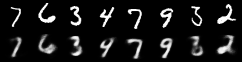

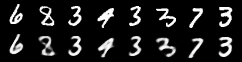

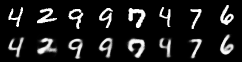

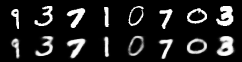

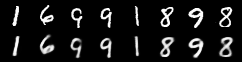

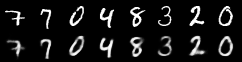

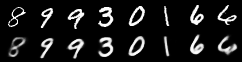

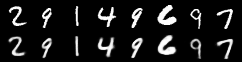

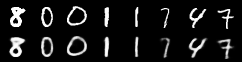

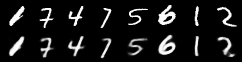

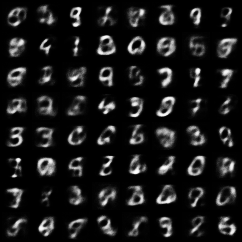

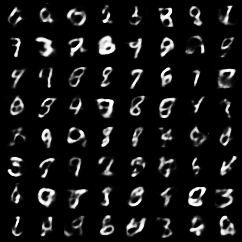

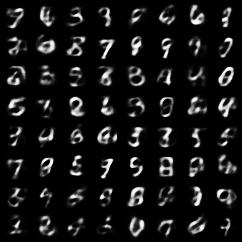

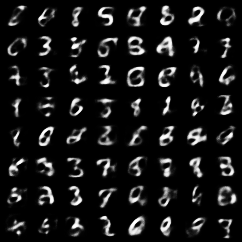

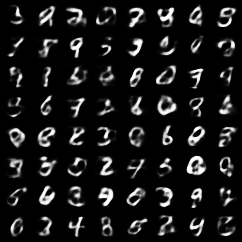

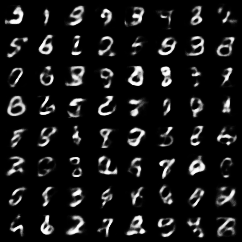

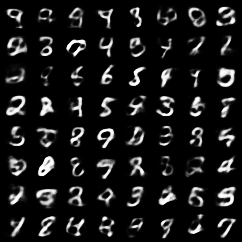

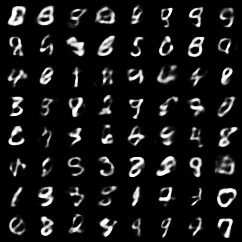

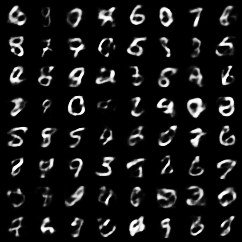

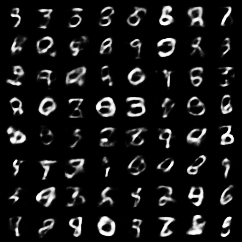

In [7]:
# display the images
from IPython.display import Image, display
from glob import glob

# Get a list of all the image files
image_files = sorted(glob('results/*.png'))

# Display the images
for image_file in image_files:
    display(Image(filename=image_file, width=100, height=100))
